In [1]:
import instruments as inst
import copy
import numpy as np
import json

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = 760
obs_mode = "MBI"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ 19866.    23740.5  -22265.5   22477.5   13337.5   22094.5  -15543.5
  21181.5   -1825.5   18824.      110.    19143.5  -13889.    16562.
  12902.    17644.5  -14556.5   16335.5   13596.5   17653.    -3387.5
  18323.5    2077.    18801.5   12197.    21847.   -14083.    21064.
  20120.5   24137.5  -22436.    22875.5   15688.5   22780.   -17572.
  21883.    20161.    24039.5  -22381.    22674.75  12334.5   22139.5
 -14414.    21295.5   -3194.    18743.5    1604.5   19184.5  -14446.
  16557.    13502.    17758.   -13795.5   16484.5   13102.    17583.5
  -1688.5   18628.      432.    18979.5   13512.5   22046.   -15333.
  21198.5    3221.5   20141.    -4612.    20053.    17069.5   23260.
 -18755.5   22276.    20285.    24323.   -22433.    22960.    11280.5
  22175.   -13264.    21412.    -4602.    18669.     3141.5   19245.
 -14799.5   16621.5   13886.    17961.   -12891.    16749.    12270.
  17794.     -109.    18976.    -1109.    19212.    -9865.5   1743

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
# Loading in previous fit from vampires_calibration
filename = "750-50_restrictive_HWP_FLC_no_IMR_offset_fixed_EM_gain_with_dichroic_best_fit.txt"
with open(filename, "r") as f:
    past_fit = json.load(f)

print(past_fit)

theta_pol = past_fit["lp"]["theta"]
delta_HWP = past_fit["hwp"]["phi"] 
offset_HWP = past_fit["hwp"]["delta_theta"]
delta_derot = past_fit["image_rotator"]["phi"] 
delta_opts = past_fit["optics"]["phi"]
epsilon_opts = past_fit["optics"]["epsilon"]
rot_opts = past_fit["optics"]["theta"]
delta_FLC = past_fit["flc"]["phi"] 
rot_FLC = past_fit["flc"]["delta_theta"]
em_gain = 1.0798052820150867 # from EM gain measurements

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
# theta_pol = 0
# delta_HWP = 0.451  # Add your actual delta_HWP value
# offset_HWP = -2.642  # Add your actual offset_HWP value
# delta_derot = 0.32  # Add your actual delta_derot value
# offset_derot = 0  # Add your actual offset_derot value
# delta_opts = 0  # Add your actual delta_opts value
# epsilon_opts = 0  # Add your actual epsilon_opts value
# rot_opts = 0  # Add your actual rot_opts value
# delta_FLC = 0.5  # Add your actual delta_FLC value
# rot_FLC = 0  # Add your actual rot_FLC value
# em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "dichroic": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 0, "epsilon": 0, "theta" : 0},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_derot, "theta": 0, "delta_theta": 0},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        }
    }
}

{'dichroic': {'phi': -0.15060529133346875, 'epsilon': 0.2947260746883915, 'theta': 35.808129724830195}, 'flc': {'phi': 3.5231674749347714, 'delta_theta': 2.547063907771257}, 'optics': {'phi': 0.8366868576245823, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}, 'image_rotator': {'phi': 3.0680237129197785}, 'hwp': {'phi': 2.9838983981947838, 'delta_theta': 0.5155838549975353}, 'lp': {'theta': 0.674229408746958}}


In [4]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.46951062 0.46938059 0.01104893 0.        ]
 [0.46951062 0.46938059 0.01104893 0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

{'dichroic': {'phi': -0.15060529133346875, 'epsilon': 0.2947260746883915, 'theta': 35.808129724830195}, 'flc': {'phi': 3.5231674749347714, 'delta_theta': 2.547063907771257}, 'optics': {'phi': 0.8366868576245823, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}, 'image_rotator': {'phi': 3.0680237129197785}, 'hwp': {'phi': 2.9838983981947838, 'delta_theta': 0.5155838549975353}, 'lp': {'theta': 0.674229408746958}}
logl value: 2084.1645418577473


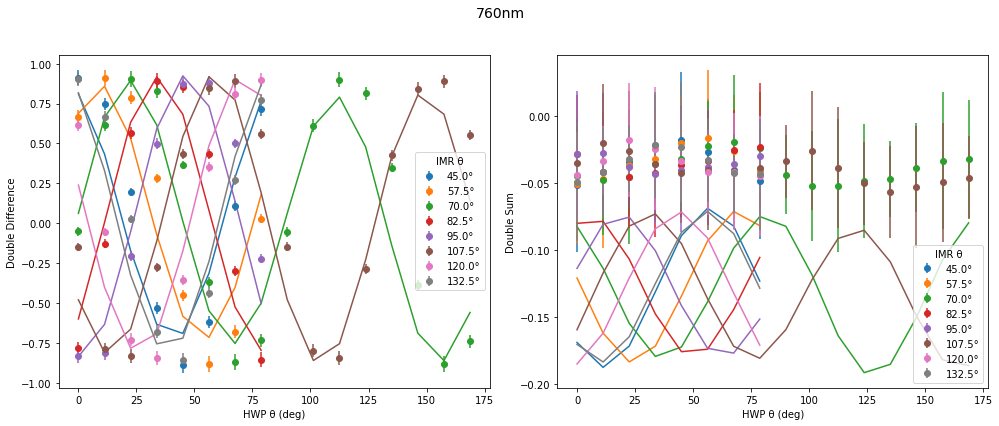

In [5]:
# Fittin for all parameters
p0 = past_fit

print(p0)

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'dichroic': {'phi': -0.15060529133346875, 'epsilon': 0.2947260746883915, 'theta': 35.808129724830195}, 'flc': {'phi': 3.5231674749347714, 'delta_theta': 2.547063907771257}, 'optics': {'phi': 0.8366868576245823, 'epsilon': 3.887450379959534e-09, 'theta': -59.919309379978884}, 'image_rotator': {'phi': 3.0680237129197785}, 'hwp': {'phi': 2.9838983981947838, 'delta_theta': 0.5155838549975353}, 'lp': {'theta': 0.674229408746958}}
Iteration #: 1
logl_value: 318.72478841105936
Best Fit Parameters: [-3.48815405e-01  7.45073440e-04  6.79874683e+01  3.52045110e+00
  4.98654281e+00  1.42237521e+00  6.78616042e-10 -8.99540313e+01
  3.13217343e+00  3.28224419e+00  3.40962417e-01 -1.13511826e-01]


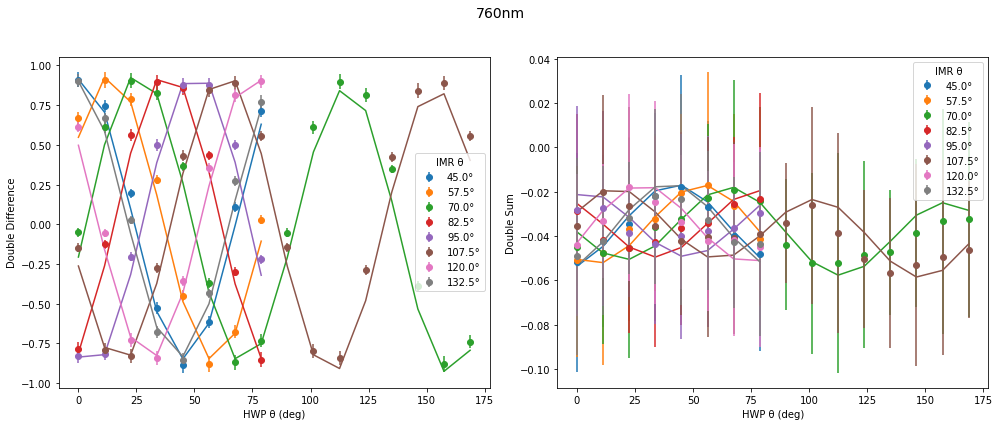

After p0: {'dichroic': {'phi': -0.34881540508429376, 'epsilon': 0.0007450734399824569, 'theta': 67.98746832587506}, 'flc': {'phi': 3.5204511020350413, 'delta_theta': 4.986542810995974}, 'optics': {'phi': 1.4223752090869235, 'epsilon': 6.786160424728705e-10, 'theta': -89.95403128786603}, 'image_rotator': {'phi': 3.1321734281010674}, 'hwp': {'phi': 3.282244193599075, 'delta_theta': 0.3409624174942856}, 'lp': {'theta': -0.1135118264822863}}
Before p0: {'dichroic': {'phi': -0.34881540508429376, 'epsilon': 0.0007450734399824569, 'theta': 67.98746832587506}, 'flc': {'phi': 3.5204511020350413, 'delta_theta': 4.986542810995974}, 'optics': {'phi': 1.4223752090869235, 'epsilon': 6.786160424728705e-10, 'theta': -89.95403128786603}, 'image_rotator': {'phi': 3.1321734281010674}, 'hwp': {'phi': 3.282244193599075, 'delta_theta': 0.3409624174942856}, 'lp': {'theta': -0.1135118264822863}}
Iteration #: 2
logl_value: 317.1045140924757
Best Fit Parameters: [-1.51913006e+00  4.90765838e-04  8.37703434e+01 

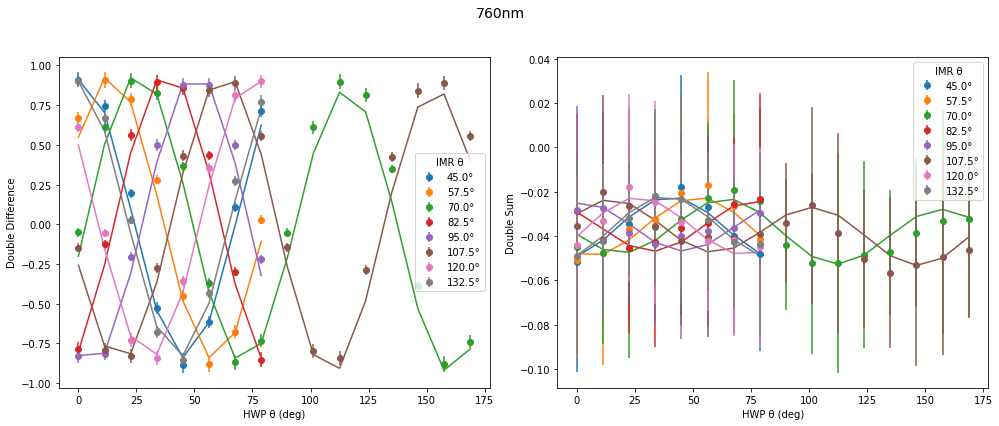

After p0: {'dichroic': {'phi': -1.5191300568466848, 'epsilon': 0.0004907658381824819, 'theta': 83.77034335296761}, 'flc': {'phi': 3.4761597261214474, 'delta_theta': 4.9769734466289215}, 'optics': {'phi': 1.8377799405553357, 'epsilon': 2.0559239262454045e-08, 'theta': -87.47728032785902}, 'image_rotator': {'phi': 3.1349805067554932}, 'hwp': {'phi': 3.2822851315422383, 'delta_theta': 0.17814609575970763}, 'lp': {'theta': -2.181808943904021}}


In [6]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds_dict = {
    # "wollaston": {
    #     "transmission_ratio": (0.8, 1.2)
    # },
    "dichroic": {
        "phi": (-2 * np.pi, 2 * np.pi),
        "epsilon": (0, 1),
        "theta": (-90, 90)
    },
    "flc": {
        "phi": (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),
        "delta_theta": (-5, 5)
    },
    "optics": {
        "phi": (-np.pi, np.pi),
        "epsilon": (0, 0.1),
        "theta": (-90, 90)
    },
    "image_rotator": {
        "phi": (
            (delta_derot - delta_derot * 0.1),
            (delta_derot + delta_derot * 0.1)
        )
    },
    "hwp": {
        "phi": (
            (delta_HWP - delta_HWP * 0.1),
            (delta_HWP + delta_HWP * 0.1)
        ),
        "delta_theta": (-5, 5)
    },
    "lp": {
        "theta": (-5, 5)
    }
}

# Now flatten the bounds in the same order as p0_keywords
for (comp, param), val in zip(p0_keywords, p0_values):
    lower, upper = bounds_dict[comp][param]
    if not (lower <= val <= upper):
        print(f"{comp}.{param} = {val} is outside bounds {lower} to {upper}")
bounds = [bounds_dict[comp][param] for comp, param in p0_keywords]

# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

    filename = f"{wavelength_string}_restrictive_HWP_FLC_no_IMR_offset_with_dichroic_best_fit_old_fit_values.txt"
    with open(filename, 'w') as f:
        json.dump(p0, f, indent=4)

# Step 6: Plot model with best fit

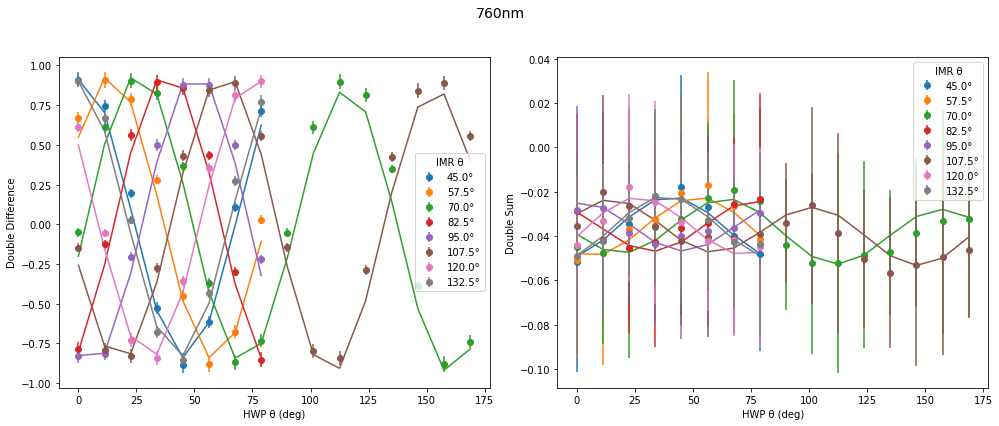

In [7]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)